Inverse design classification based on R and T calculation from forward RCWA simulation for  system SiO2\TiN\TiO2 (two layers of 30/90 nm thickness).
For substrate I've added dielectric constant of quartz 3.76 into TRCWA TRCWA_BOTTOM_LAYER_EPS
Calculations for wavelength filtering are on colab version.


**1.**

In [1]:
%load_ext autoreload
%autoreload 2

# Append root folder in case you haven't installed NIDN
import sys
sys.path.append("../")

import nidn
nidn.set_log_level("INFO")

14:12:01|NIDN-INFO| Initialized NIDN for cpu
14:12:01|NIDN-INFO| Using double precision
14:12:01|NIDN-INFO| Switching log level to warning.


In [2]:
import torch

In [3]:
from nidn import MaterialCollection

In [4]:
#I've used this to check if the data for TiN are properly added into Material collection.
c = MaterialCollection((350,400))

In [5]:
print(c.epsilon_matrix)

tensor([[ 0.7524+3.3186e-01j,  0.7524+3.3186e-01j],
        [ 6.0667+1.4778e-04j,  6.0667+1.4778e-04j],
        [ 2.6526+1.5116e+01j,  2.6526+1.5116e+01j],
        [ 4.1185+8.1177e-05j,  4.1185+8.1177e-05j],
        [-0.8757+4.0293e+00j, -0.8757+4.0293e+00j],
        [-5.5660+5.5753e+00j, -5.5660+5.5753e+00j],
        [-8.2060+9.1085e+00j, -8.2060+9.1085e+00j],
        [ 0.7030+8.4840e-02j,  0.7030+8.4840e-02j],
        [ 2.0608+4.8904e+00j,  2.0608+4.8904e+00j],
        [ 3.3499-1.9042e-01j,  3.3499-1.9042e-01j],
        [ 2.0079+8.5020e-03j,  2.0079+8.5020e-03j]])


In [6]:
print(c.material_names)

['tantalum_pentoxide', 'silicon_nitride', 'germanium', 'aluminium_nitride', 'indium_arsenide', 'gallium_arsenide', 'aluminium_arsenide', 'titanium_nitride', 'titanium_oxide', 'aluminium_oxide', 'zinc_oxide']


In [7]:
print(c.materials_folder)

/home/t/miniconda3/lib/python3.10/site-packages/nidn/materials/data/


In [8]:
# Start with the default config
cfg = nidn.load_default_cfg()
cfg.use_gpu = True

In [9]:
# Print run config
nidn.print_cfg(cfg)

name                   : example_name   |use_gpu                : 1              |seed                   : 100            |
model_type             : siren          |iterations             : 3000           |learning_rate          : 8e-05          |
type                   : regression     |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : -100.0         |real_max_eps           : 100.0          |imag_min_eps           : 0.0            |
imag_max_eps           : 3.0            |solver                 : TRCWA          |Nx                     : 1              |
Ny      

In [10]:
# Titanium Nitride/Titanium Oxide Uniform on glass
# Set grid specifics
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 2
cfg.N_freq = 128
cfg.TRCWA_BOTTOM_LAYER_EPS = 3.76
cfg.TRCWA_L_grid = [[0.1,0.0],[0.0,0.1]]
cfg.TRCWA_NG = 11
cfg.PER_LAYER_THICKNESS = [0.03, 0.09]
cfg.freq_distribution = "linear"

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 3e-7
cfg.physical_wavelength_range[1] = 1e-6

# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

In [11]:
# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)

layer_builder = nidn.LayerBuilder(cfg)

In [12]:
# Uniform Titanium nitride
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_nitride")
eps_grid[:,:,1,:] = layer_builder.build_uniform_layer("titanium_oxide")


/home/t/miniconda3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


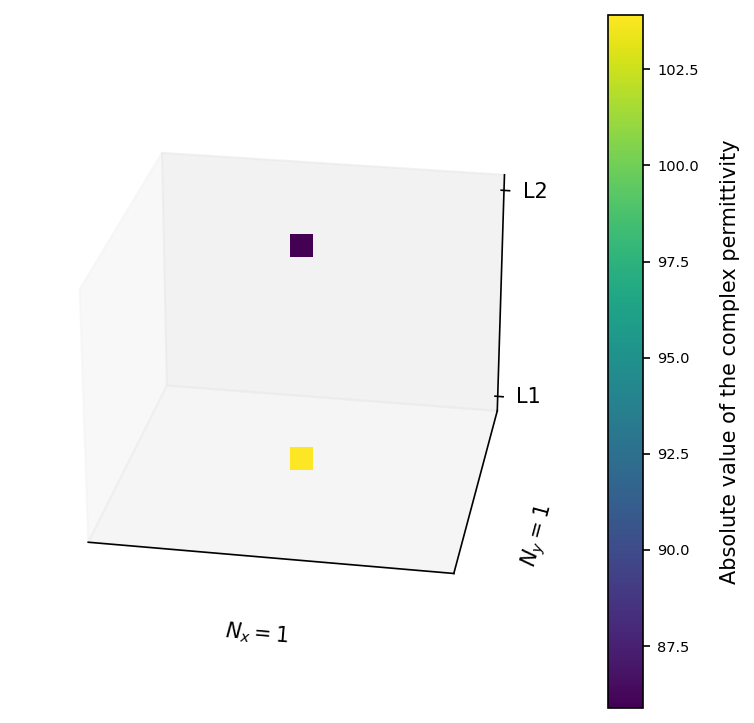

In [13]:
# Plot the abs values of the produced grid
nidn.plot_epsilon_grid(eps_grid,cfg)

In [14]:
# Print run config
nidn.print_cfg(cfg)

name                   : example_name   |use_gpu                : 1              |seed                   : 100            |
model_type             : siren          |iterations             : 3000           |learning_rate          : 8e-05          |
type                   : regression     |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : -100.0         |real_max_eps           : 100.0          |imag_min_eps           : 0.0            |
imag_max_eps           : 3.0            |solver                 : TRCWA          |Nx                     : 1              |
Ny      

In [15]:
import numpy as np

def save_array_as_txt(array, filename):
   np.savetxt(filename, array)








In [16]:
my_array = 1000*nidn.freq_to_wl(cfg.target_frequencies)
save_array_as_txt(my_array, 'output.txt')#udji u NIDN

In [22]:
#ovde ubaci fajlove za R i T, tu gde je output. ovo dole poslozi dva csv fajla, 
#posle dole je dodat deo koji pročita listu

import csv

# read in experimental data from text file
data = np.loadtxt('TiN_TiO2_25_75_T_RawData_calculated.txt', ndmin=2)
wavelength_exp = data[:, 0]  # in nm
transm_exp = data[:, 1]

# read in NIDN wavelengths from text file
nidn_data = np.loadtxt('output.txt', ndmin=2)
wavelengths_nidn = nidn_data[:, 0]  # in nm

# match NIDN wavelengths to closest experimental wavelength
indices = []
for wavelength in wavelengths_nidn:
    idx = np.argmin(np.abs(wavelength_exp - wavelength))
    indices.append(idx)

# save matched experimental wavelength and reflectivity values in CSV file
with open('matched_data_T_25_75.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['NIDN Wavelength (nm)', 'Matched Wavelength (nm)', 'T'])
    for i, idx in enumerate(indices):
        writer.writerow([wavelengths_nidn[i], wavelength_exp[idx], transm_exp[idx]/100])




In [23]:


# read in experimental data from text file
data = np.loadtxt('TiN_TiO2_25_75_staklo_Rspec_RawData_calculated.txt', ndmin=2)
wavelength_exp = data[:, 0]  # in nm
reflectivity_exp = data[:, 1]

# read in NIDN wavelengths from text file
nidn_data = np.loadtxt('output.txt', ndmin=2)
wavelengths_nidn = nidn_data[:, 0]  # in nm

# match NIDN wavelengths to closest experimental wavelength
indices = []
for wavelength in wavelengths_nidn:
    idx = np.argmin(np.abs(wavelength_exp - wavelength))
    indices.append(idx)

# save matched experimental wavelength and reflectivity values in CSV file
with open('matched_data_R_25_75.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['NIDN Wavelength (nm)', 'Matched Wavelength (nm)', 'R'])
    for i, idx in enumerate(indices):
        writer.writerow([wavelengths_nidn[i], wavelength_exp[idx], reflectivity_exp[idx]/100])




In [24]:
import csv

# Define the CSV file path and the column index (starting from 0)
csv_file_path = "matched_data_R_25_75.csv"
column_index = 2

# Read the specified column from the CSV file as a list with two decimal places
R = []
with open(csv_file_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for index, row in enumerate(reader):
        if index >= 128:
            break
        value = float(row[column_index])
        formatted_value = round(value, 2)  # Round to two decimal places
        R.append(formatted_value)

# Print the list of values
print(R)

# Save the values as a list in a text file



[0.07, 0.07, 0.07, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.08, 0.08, 0.09, 0.09, 0.1, 0.1, 0.11, 0.12, 0.13, 0.13, 0.14, 0.15, 0.15, 0.16, 0.17, 0.17, 0.18, 0.19, 0.19, 0.2, 0.2, 0.21, 0.21, 0.22, 0.22, 0.22, 0.23, 0.23, 0.23, 0.23, 0.23, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.24, 0.25, 0.25, 0.25, 0.25, 0.26, 0.26, 0.26, 0.27, 0.27, 0.28, 0.28, 0.29, 0.3, 0.31, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.36, 0.37, 0.38, 0.39, 0.39, 0.4, 0.4, 0.4, 0.41, 0.41, 0.41, 0.41, 0.4, 0.4, 0.39, 0.39, 0.38, 0.37, 0.36, 0.34, 0.33, 0.31, 0.29, 0.27, 0.25, 0.23, 0.21, 0.19, 0.18, 0.17, 0.16, 0.16, 0.17, 0.17, 0.19, 0.21, 0.22, 0.24, 0.26, 0.28, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.35, 0.36, 0.36, 0.36, 0.36, 0.36, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37, 0.37]


In [25]:

# Define the CSV file path and the column index (starting from 0)
csv_file_path = "matched_data_T_25_75.csv"
column_index = 2

# Read the specified column from the CSV file as a list with two decimal places
T = []
with open(csv_file_path, 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for index, row in enumerate(reader):
        if index >= 128:
            break
        value = float(row[column_index])
        formatted_value = round(value, 2)  # Round to two decimal places
        T.append(formatted_value)

# Print the list of values
print(T)



[0.4, 0.4, 0.4, 0.4, 0.39, 0.39, 0.39, 0.39, 0.39, 0.39, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.42, 0.42, 0.42, 0.42, 0.42, 0.43, 0.43, 0.43, 0.43, 0.43, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.43, 0.43, 0.43, 0.42, 0.42, 0.41, 0.41, 0.4, 0.4, 0.39, 0.39, 0.38, 0.38, 0.37, 0.37, 0.36, 0.36, 0.36, 0.36, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.34, 0.34, 0.33, 0.32, 0.3, 0.28, 0.27, 0.24, 0.22, 0.2, 0.18, 0.15, 0.14, 0.11, 0.1, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# my_array = 1000*nidn.freq_to_wl(cfg.target_frequencies)
# save_array_as_txt(my_array, 'output.txt')#udji u NIDN

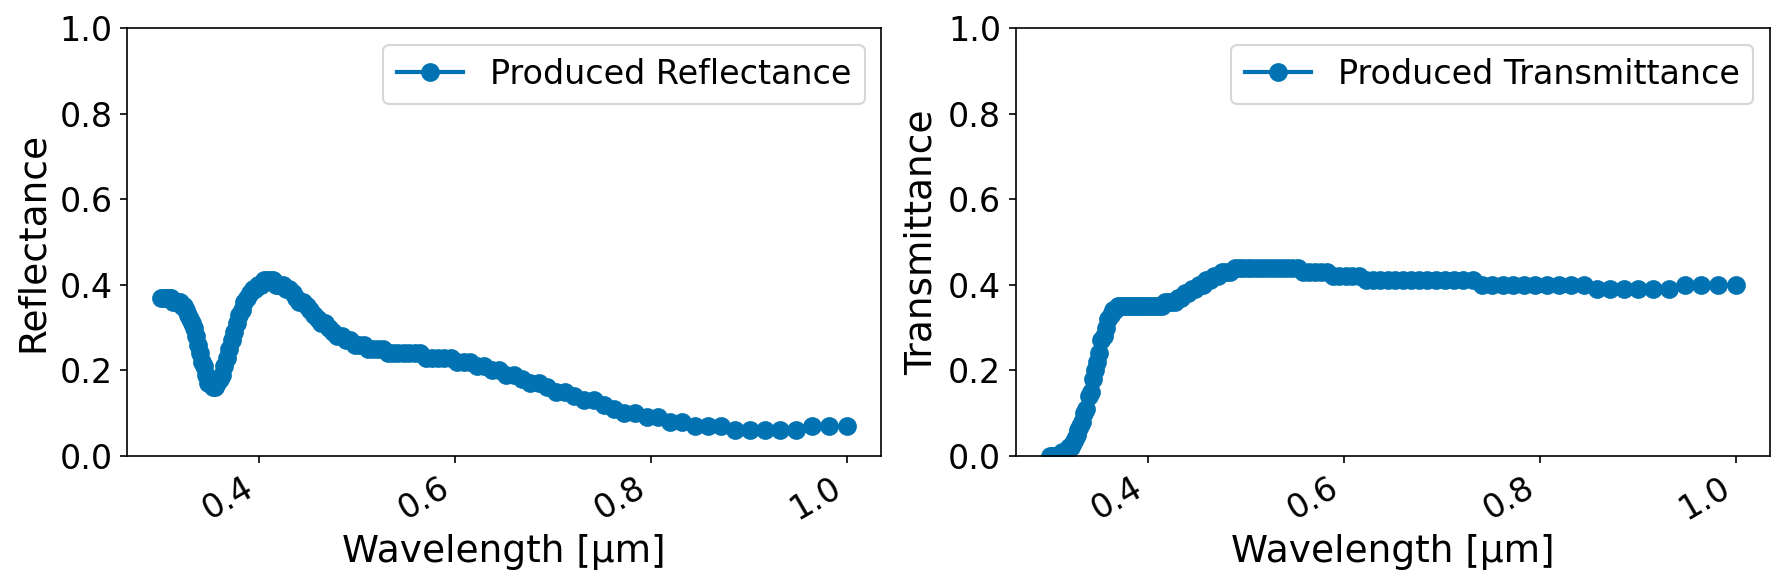

In [26]:
nidn.plot_spectrum(cfg,R,T)

**2.Classification problem based on previous calculation.**


In [27]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 2 # Choose number of layers

cfg.type = "classification" # Choose type as described above
cfg.iterations = 1000 # Set number of training iterations (that is forward model evaluations) to perform

In [28]:
cfg.TRCWA_BOTTOM_LAYER_EPS = 3.76

cfg.PER_LAYER_THICKNESS = [0.03,0.09]
cfg.use_gpu = True

In [29]:
cfg.target_reflectance_spectrum =   R
cfg.target_transmittance_spectrum = T

In [30]:
nidn.print_cfg(cfg)

name                   : example_name   |use_gpu                : 1              |seed                   : 100            |
model_type             : siren          |iterations             : 1000           |learning_rate          : 8e-05          |
type                   : classification |reg_loss_weight        : 0.05           |use_regularization_loss: 1              |
L                      : 1.0            |absorption_loss        : 0              |n_neurons              : 100            |
hidden_layers          : 9              |encoding_dim           : 4              |siren_omega            : 1.0            |
add_noise              : 0              |noise_scale            : 0.001          |eps_oversampling       : 1              |
real_min_eps           : -100.0         |real_max_eps           : 100.0          |imag_min_eps           : 0.0            |
imag_max_eps           : 3.0            |solver                 : TRCWA          |Nx                     : 1              |
Ny      

In [31]:
nidn.run_training(cfg);

14:17:36|NIDN-INFO| ###  New Best=0.1587 with SpectrumLoss=0.1541 ### L1=0.1541
14:17:36|NIDN-INFO| It=0     Loss=0.1587   |  weighted_avg=0.1587  |  SpectrumLoss=0.1541 | L1=0.1541
14:17:36|NIDN-INFO| ###  New Best=0.1348 with SpectrumLoss=0.1302 ### L1=0.1302
14:17:37|NIDN-INFO| ###  New Best=0.1226 with SpectrumLoss=0.1180 ### L1=0.1180
14:17:38|NIDN-INFO| ###  New Best=0.1008 with SpectrumLoss=0.0963 ### L1=0.0963
14:17:39|NIDN-INFO| ###  New Best=0.0875 with SpectrumLoss=0.0831 ### L1=0.0831
14:17:39|NIDN-INFO| ###  New Best=0.0751 with SpectrumLoss=0.0712 ### L1=0.0712
14:17:39|NIDN-INFO| It=5     Loss=0.0751   |  weighted_avg=0.1132  |  SpectrumLoss=0.0712 | L1=0.0712
14:17:40|NIDN-INFO| ###  New Best=0.0682 with SpectrumLoss=0.0647 ### L1=0.0647
14:17:41|NIDN-INFO| ###  New Best=0.0603 with SpectrumLoss=0.0568 ### L1=0.0568
14:17:42|NIDN-INFO| ###  New Best=0.0521 with SpectrumLoss=0.0486 ### L1=0.0486
14:17:43|NIDN-INFO| It=10    Loss=0.0570   |  weighted_avg=0.0890  |  Spectr

KeyboardInterrupt: 

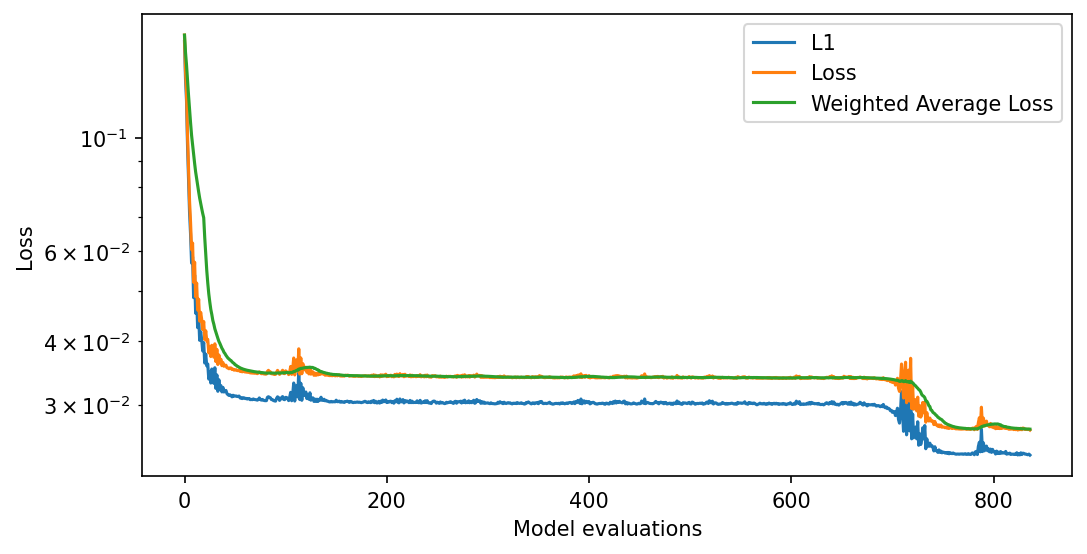

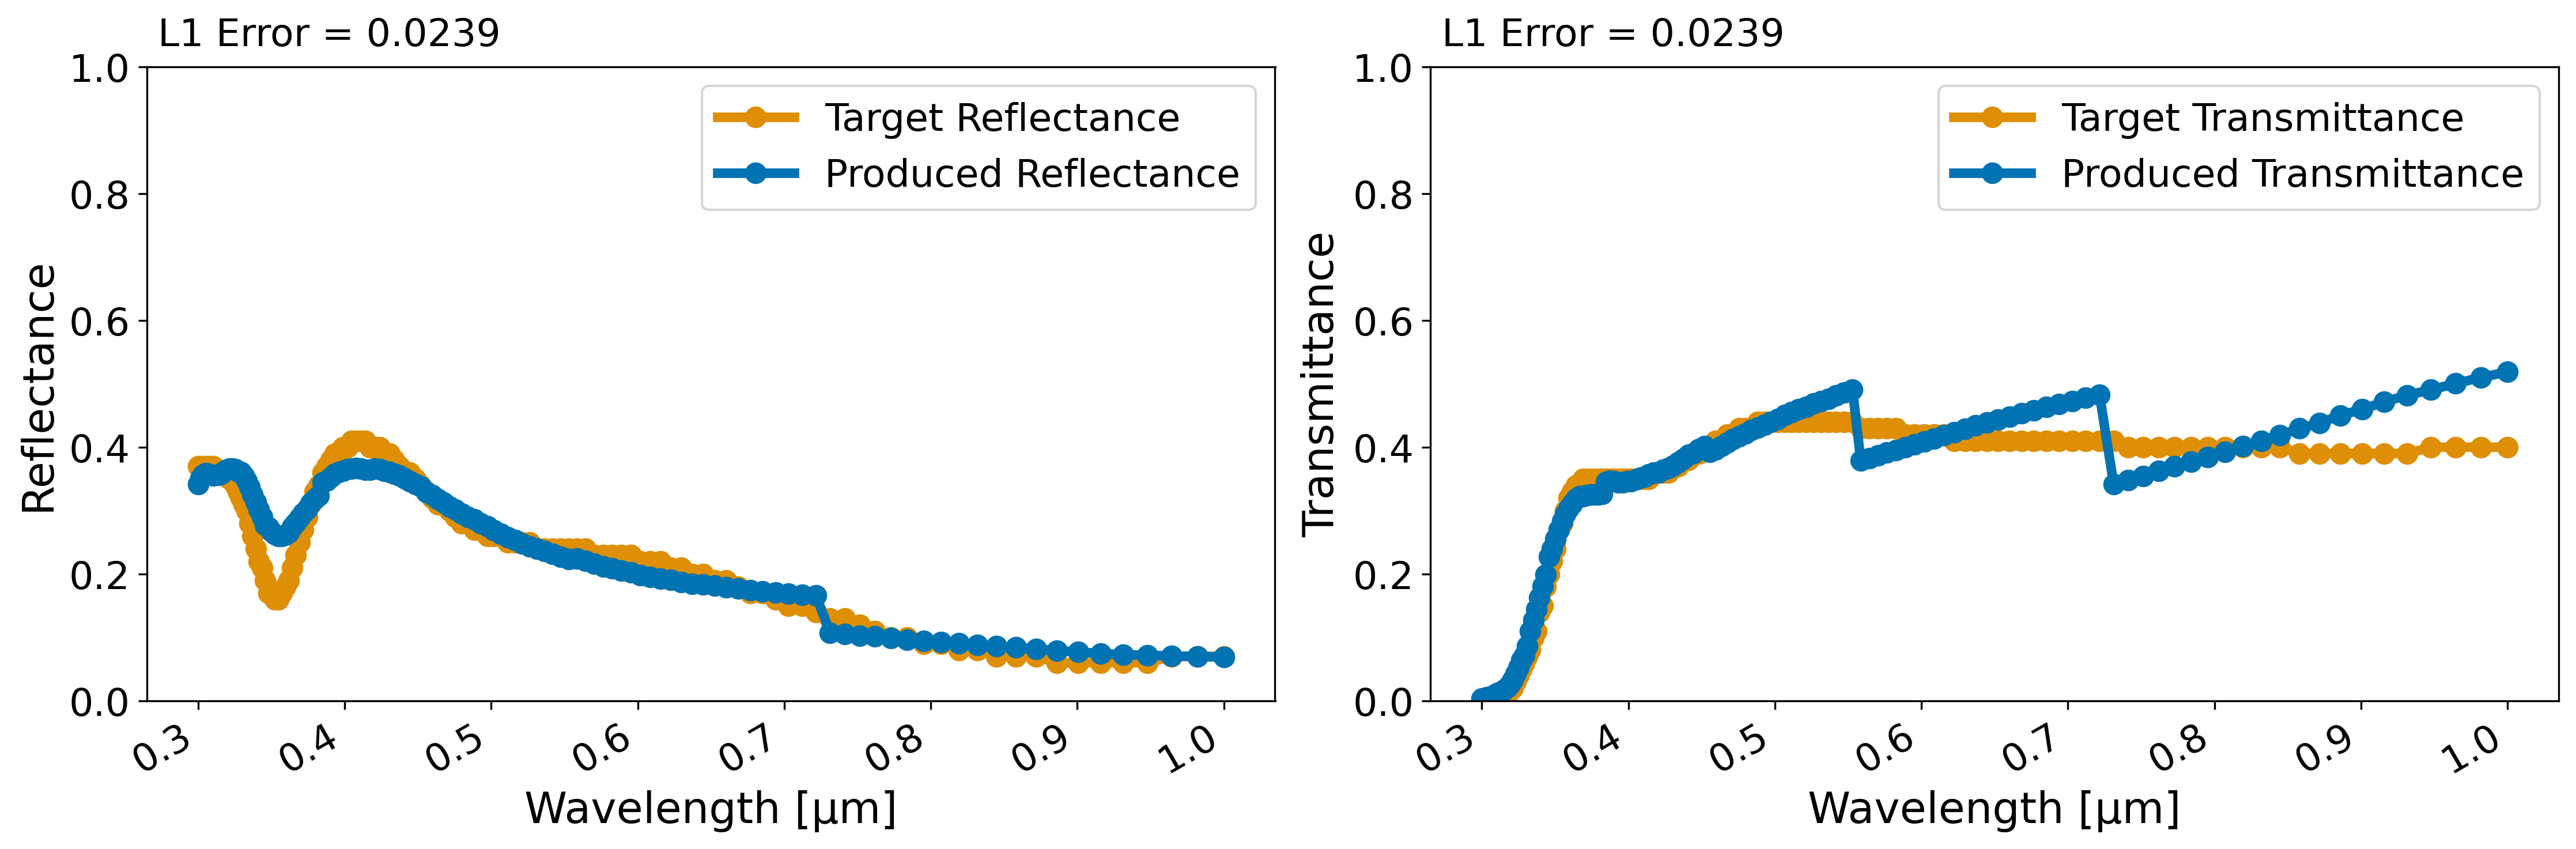

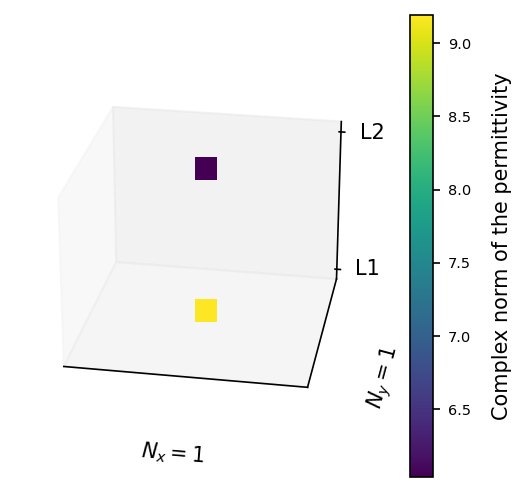

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

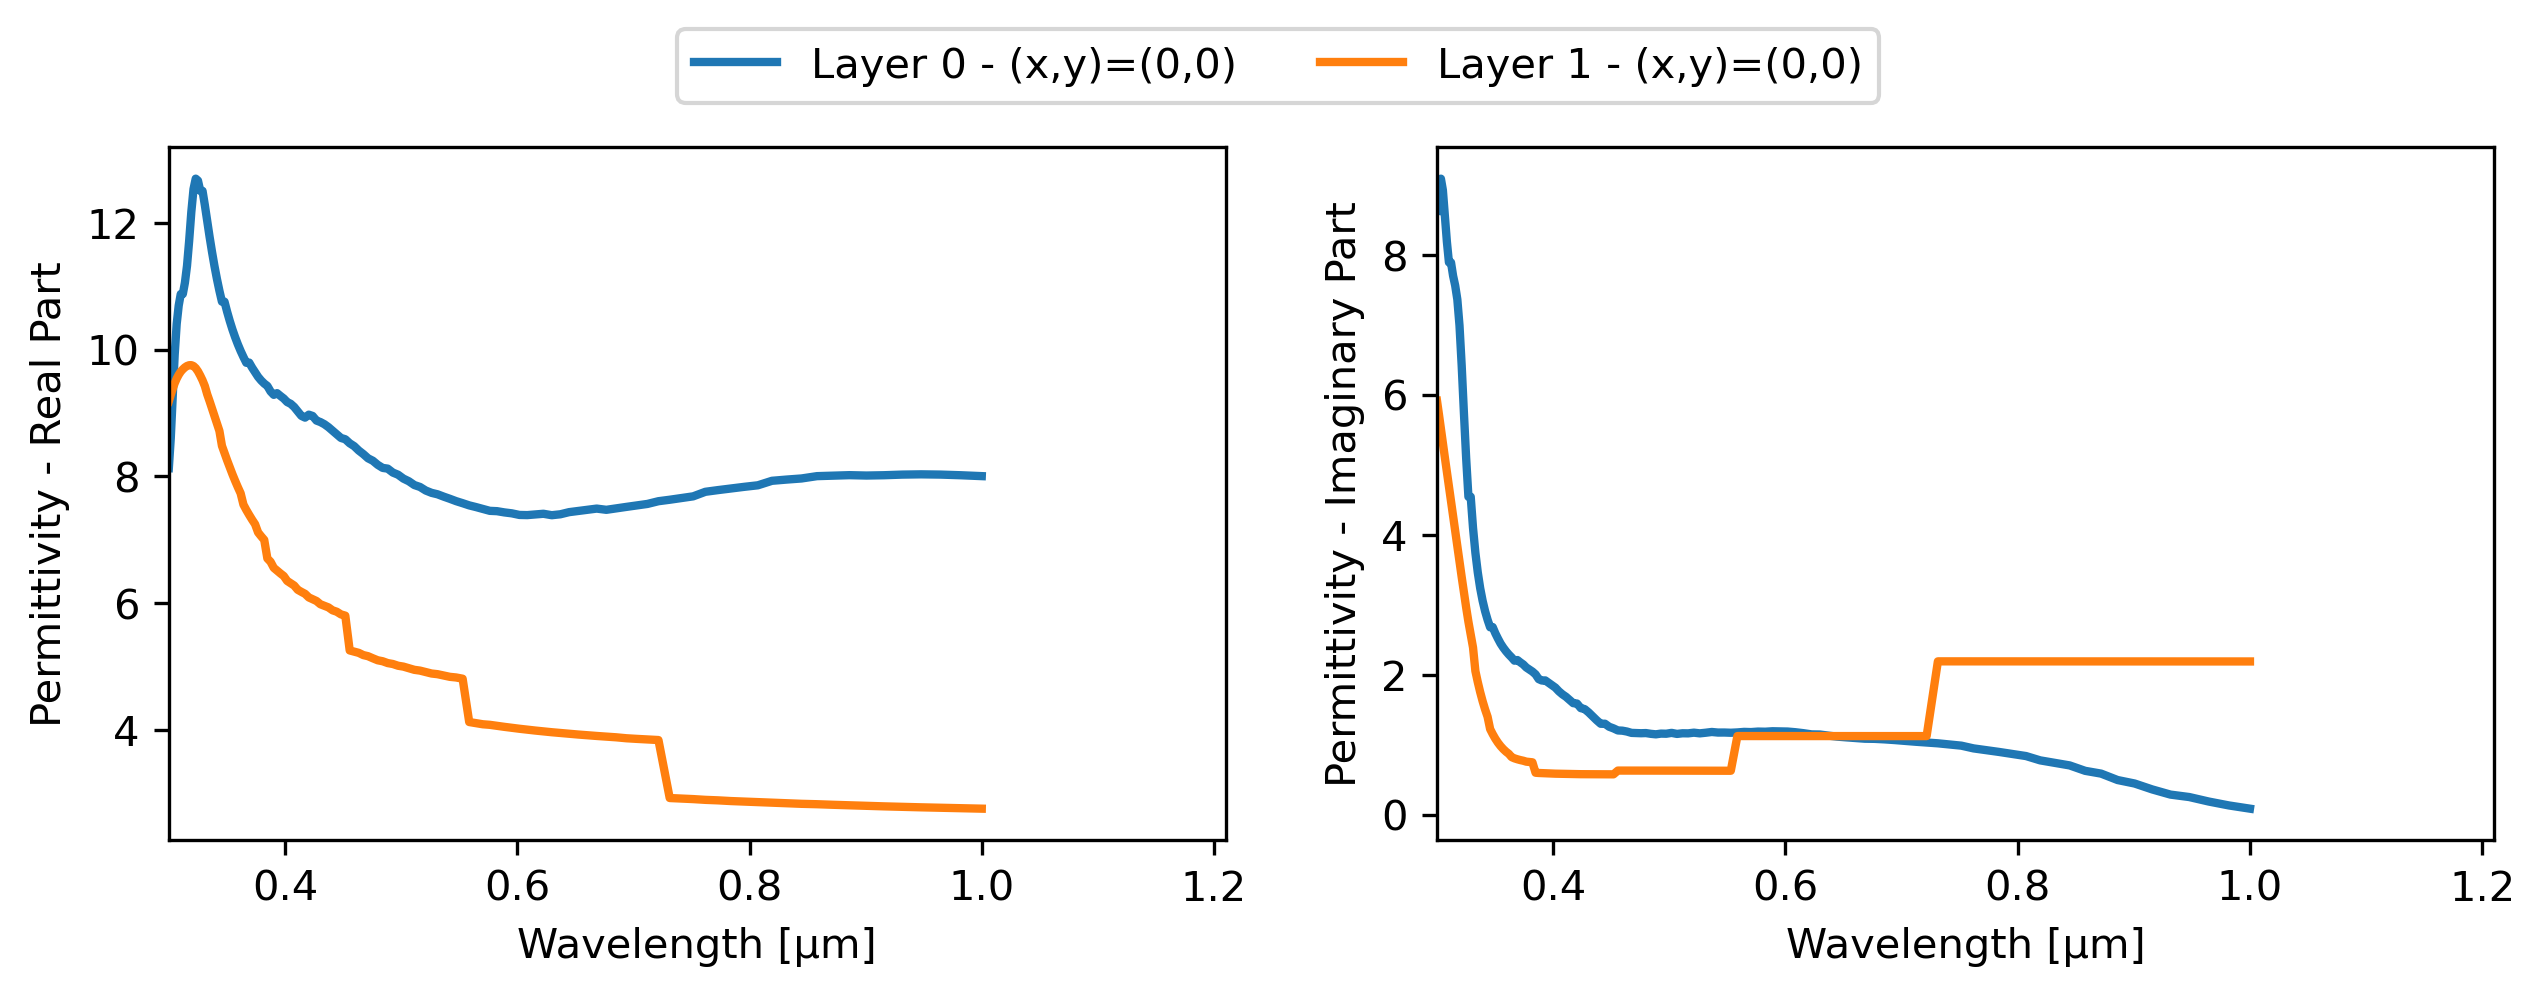

In [32]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg,compare_to_material=["titanium_oxide"])

**3. Regression problem**

In [ ]:
cfg.pop("model",None); # Forget the old model
cfg.Nx = 1 # Set layer size  to 1x1 (interpreted as uniform)
cfg.Ny = 1
cfg.N_layers = 2 # Choose number of layers
cfg.real_min_eps = 0.0
cfg.real_max_eps = 40.0
cfg.imag_min_eps = 0.0
cfg.imag_max_eps = 30.0


cfg.type = "regression" # Choose type as described above
cfg.iterations = 1000 # Set number of training iterations (that is forward model evaluations) to perform

In [ ]:
cfg.TRCWA_BOTTOM_LAYER_EPS = 3.76

cfg.PER_LAYER_THICKNESS = [0.03,0.09]

In [ ]:
cfg.target_reflectance_spectrum =   R
cfg.target_transmittance_spectrum = T

In [ ]:
nidn.run_training(cfg);

In [ ]:
nidn.plot_losses(cfg)
nidn.plot_spectra(cfg)
nidn.plot_model_grid(cfg)
nidn.plot_eps_per_point(cfg,compare_to_material=["titanium_oxide", "titanium_nitride"])

In [ ]:
import numpy as np

def calculate_refractive_index(wavelengths, real_part, imaginary_part):
    speed_of_light = 299792458  # m/s

    frequencies = speed_of_light / (wavelengths * 1e-9)  # Convert wavelength from nm to m

    delta_wavelength = np.diff(wavelengths)[0]  # Assume evenly spaced wavelength data
    delta_frequency = speed_of_light / (wavelengths[0] * 1e-9) * (1 - 1 / (len(wavelengths) + 1))

    integrals = np.cumsum(imaginary_part * delta_wavelength)
    integrals -= (0.5 * imaginary_part[0] * delta_wavelength)
    integrals *= (2 / np.pi)

    real_part_kk = real_part[0] + (2 / np.pi) * integrals

    refractive_index = np.sqrt(1 + (real_part_kk / (2 * np.pi * frequencies))**2)

    return refractive_index

# Example usage
wavelengths = np.array([400, 500, 600])  # Wavelengths in nm
real_part = np.array([2.5, 3.0, 2.8])
imaginary_part = np.array([0.1, 0.2, 0.05])

refractive_index = calculate_refractive_index(wavelengths, real_part, imaginary_part)
print(refractive_index)
